# **Build a CNN on MNIST Dataset**

# 0. Set Up

For this tutorial, we will be using ``numpy`` to generate data and all operations, ``matplotlib`` to render and plot images and of course ``nets`` for ``Tensor`` operations and computational graph creation. We will set the ``SEED`` for random numbers from ``numpy``, so each time we reload the notebook the results will be the same as numbers will be generated in the same way. Finally, we set an autoreload with ``%load_ext autoreload`` and ``%autoreload 2`` for debug mode purposes. This enable the notebook to reload the modules each time we run a cell, so it keeps everything up-to-date. More info [on StackOverflow](http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython).

Let's load the packages we need to run our tests:

In [1]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.style.use('seaborn-darkgrid')
# Change the font ?
font = {'size'   : 15}
plt.rc('font', **font)

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
from psutil import virtual_memory


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

'nvidia-smi' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.
Your runtime has 8.5 gigabytes of available RAM



In [3]:
import sys

sys.path.append("../../")

In [4]:
# Let's fix the seed

SEED = 42
rd.seed(SEED)
np.random.seed(SEED)

# 1. Download the dataset

In [7]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt

import nets
import nets.datasets as datasets

# IMPORTANT: normalize the data !
# 1. reshape from (data_length, 32, 32, 3) to (data_length, 32 * 32 * 3)
reshape = lambda x: x.reshape(-1, 784)
# 2. scale the data: data = (data - mean) / std
normalize = lambda x: (x - np.mean(x, axis=1, keepdims=True)) / np.std(x, axis=1, keepdims=True)
# 3. all together
transform = lambda x: normalize(reshape(x)).reshape(-1, 1, 28, 28)#.transpose(0, 3, 1, 2)

# Download the training and testing data
train_data, test_data = datasets.MNIST.splits(transform = transform)


train_data

Download train-images-idx3-ubyte.gz from http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to .data\mnist\train-images-idx3-ubyte.gz
Downloading... 100% | [==================================================] | Done !
.data\mnist\mnist-data-py
Extracting... | NOTE: gzip files are not extracted, and moved to .data\mnist\mnist-data-py | Done !
Download train-labels-idx1-ubyte.gz from http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to .data\mnist\train-labels-idx1-ubyte.gz
Downloading... 100% | [==================================================] | Done !
.data\mnist\mnist-data-py
Extracting... | NOTE: gzip files are not extracted, and moved to .data\mnist\mnist-data-py | Done !
Download t10k-labels-idx1-ubyte.gz from http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to .data\mnist\t10k-labels-idx1-ubyte.gz
Downloading... 100% | [==================================================] | Done !
.data\mnist\mnist-data-py
Extracting... | NOTE: gzip files are not ext

Dataset MNIST(
   (data): Tensor(shape=(60000, 1, 28, 28), dtype=float64)
   (labels): Tensor(shape=(60000,), dtype=uint8)
)

In [6]:
train_data.data.cuda()
train_data.labels.cuda()

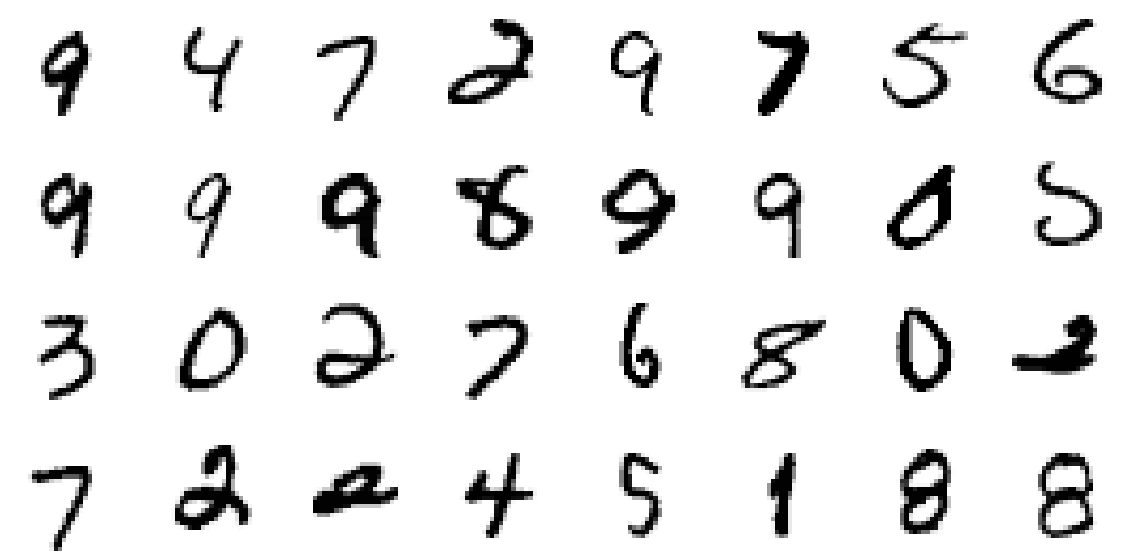

In [8]:
# CIFAR10 classes
# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Configure the mosaic to display images
fig = plt.figure(figsize = (20, 10))
columns = 8
rows = 4

# Create the mosaic
for i in range(1, columns * rows + 1):
    # Choose randomly an image
    image_index = rd.randint(0, len(train_data))
    image, label = train_data[image_index]
    # Plot it
    fig.add_subplot(rows, columns, i)
    plt.imshow(image.numpy().reshape(28, 28))
    # Remove axis and display image's label
    # plt.title(classes[label.data])
    plt.axis('off')
    
# Render
plt.show()

# 2. Load the data

In [9]:
from nets.data import Iterator

BATCH_SIZE = 64

iterator = Iterator(train_data, 
                    batch_size = BATCH_SIZE, 
                    shuffle = True)

In [10]:
import nets.nn as nn

class Classifier(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        # Input batch shape: [batch_size, num_channel, height, width]
        #         for MNIST: [batch_size,       1    ,   28  ,  28  ]
        self.conv = nn.Conv2d(1, 1, (3, 3), stride=1, pad=0)
        # Output shape: [batch_size, num_channel, height - 2, width - 2]
        #           ie: [batch_size,        1   ,      26   ,     26   ]
        
        self.pool = nn.MaxPool2d((2, 2), stride=2, pad=0)
        # Output shape: [batch_size, num_channel, height / 2, width / 2]
        #           ie: [batch_size,        1   ,      13   ,     13   ]

        
        # Input shape: [batch_size, num_channel * height * width]
        #          ie: [batch_size,              169            ]
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        # Output shape: [batch_size, hidden_dim]
        
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        
        self.layer3 = nn.Linear(hidden_dim, output_dim)
        # Output shape: [batch_size, output_dim]

    def forward(self, inputs):
        # Convolution layer
        out = self.conv(inputs)
        # Decrease the dimensions
        out = self.pool(out)
        
        # Transition from 4-d tensor to 2-d tensor
        out = out.reshape(out.shape[0], -1)
        # From: [batch_size, 1, H, W]
        #   to: [batch_size, input_dim]
        
        # Classification layer(s)
        out = nets.relu(self.layer1(out))
        out = nets.relu(self.layer2(out))
        
        # Prediction layer
        out = self.layer3(out)
        return out


model = Classifier(169, 100, 10)

# Let's check the architecture
model

Classifier(
   (conv): Conv2d(in_channels=1, out_channels=1, filter_size=(3, 3), stride=1, pad=0, bias=True)
   (pool): MaxPool2d(pool_size=(2, 2), stride=2, pad=0)
   (layer1): Linear(input_dim=169, output_dim=100, bias=True)
   (layer2): Linear(input_dim=100, output_dim=100, bias=True)
   (layer3): Linear(input_dim=100, output_dim=10, bias=True)
)

In [10]:
model.cuda()

## 5.3. Criterion & Optimizer

In [11]:
from nets.optim import SGD
from nets.nn import CrossEntropyLoss, MSELoss
from nets.nn.utils import one_hot

# How much do we update the parameters
LEARNING_RATE = 0.1

optimizer = SGD(model.parameters(), lr=LEARNING_RATE)
criterion = CrossEntropyLoss()

In [12]:
criterion.cuda()

## 5.4. Training

In [ ]:
import time
from tqdm import tqdm

# Training iterations
EPOCHS = 10

#Display the time during training
start = time.time()
# Record the loss
history = []

# Run the simulation EPOCHS times
for epoch in range(EPOCHS):
    
    # Keep track of the loss at each epoch
    epoch_loss = 0.0
    epoch_start = time.time()
    
    # Number of batches
    N  = len(iterator)

    # Predict for all batches
    trange = tqdm(iterator, ascii=True, position=0, leave=True, total=len(iterator))
    for idx, batch in enumerate(trange):
        trange.set_description(f"Epoch {epoch:4d}/{EPOCHS}")

        # Gradients accumulates, therefore we need to set them to zero at each iteration
        model.zero_grad()
        
        # Get the data from the batch
        image, label = batch    
        # Run the forward pass on the model
        predictions = model(image)
        # Get how far are the predictions from the truth (aka gold labels)
        label = one_hot(label, 10).astype(int)
        loss = criterion(predictions, label)
        
        # Compute the gradient
        loss.backward()
        # Update the parameters
        optimizer.step()
        
        # Record the loss for plotting
        loss_avg = loss.item() / BATCH_SIZE # .item() is really important, it will free the memory from the computational graph
        epoch_loss += loss_avg
        # Let's plot a progress bar in the console
        trange.set_postfix({f"train loss": f"{loss_avg:.6f}"})
    
    # Update the history of all previous loss
    history.append(epoch_loss / N)
    
    # Check the mean loss for this loop
    print(f"\nEpoch: {epoch:4d}/{EPOCHS} | loss: {epoch_loss / N:1.3E}")

# Duration of the total training loop
print('\ntime:', time.time() - start)

Epoch    0/10: : 938it [00:25, 36.64it/s, train loss=0.006496]                                                         
  0%|                                                                                          | 0/937 [00:00<?, ?it/s]


Epoch:    0/10 | loss: 1.163E-02


Epoch    1/10: : 938it [00:48, 19.31it/s, train loss=0.003954]                                                         
  0%|                                                                                          | 0/937 [00:00<?, ?it/s]


Epoch:    1/10 | loss: 6.256E-03


Epoch    2/10: : 938it [01:05, 14.36it/s, train loss=0.002692]                                                         
  0%|                                                                                          | 0/937 [00:00<?, ?it/s]


Epoch:    2/10 | loss: 5.452E-03


Epoch    3/10: : 938it [01:22, 11.34it/s, train loss=0.002167]                                                         
  0%|                                                                                          | 0/937 [00:00<?, ?it/s]


Epoch:    3/10 | loss: 4.811E-03


Epoch    4/10: : 938it [01:42,  9.14it/s, train loss=0.001924]                                                         
  0%|                                                                                          | 0/937 [00:00<?, ?it/s]


Epoch:    4/10 | loss: 4.271E-03


Epoch    5/10:   2%|#1                                           | 23/937 [00:06<01:49,  8.34it/s, train loss=0.003703]

```
Epoch:    0/10 | loss: 1.163E-02
Epoch:    1/10 | loss: 6.256E-03
```

In [ ]:
plt.plot(history)
plt.title("Loss on MNIST dataset")
plt.xlabel("epochs")
plt.ylabel("loss")

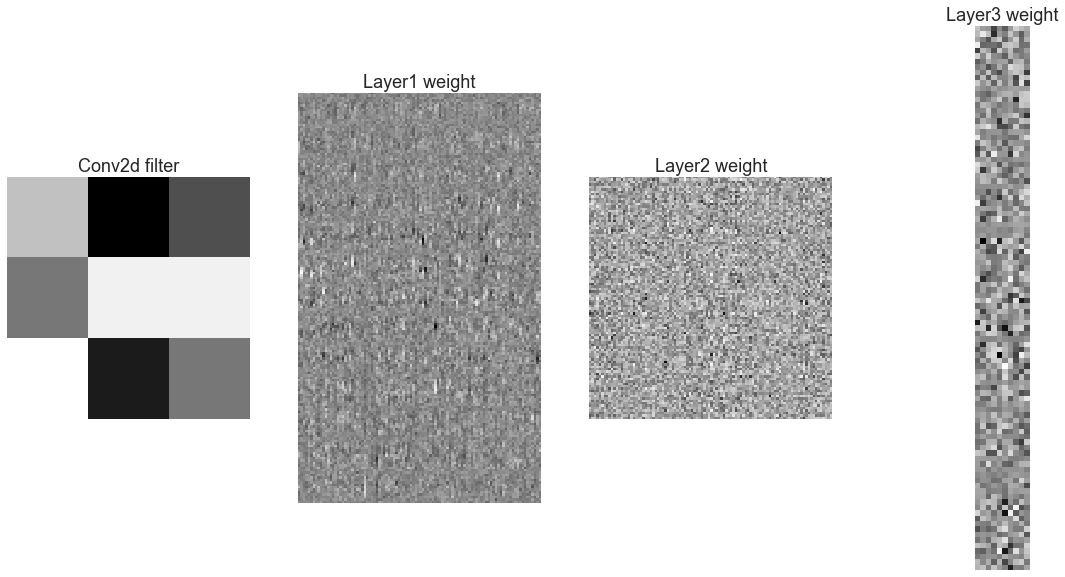

In [16]:
# Configure the mosaic to display images
fig = plt.figure(figsize = (20, 10))
columns = 4
rows = 1

# Conv2d filter
fig.add_subplot(rows, columns, 1)
conv_filter = model._modules['conv'].weight
plt.imshow(conv_filter.numpy().reshape(3, 3))
plt.title('Conv2d filter')
plt.axis('off')

# Linear1 weight
fig.add_subplot(rows, columns, 2)
layer1_weightr = model._modules['layer1'].weight
plt.imshow(layer1_weightr.numpy())
plt.title('Layer1 weight')
plt.axis('off')
  
# Linear2 weight
fig.add_subplot(rows, columns, 3)
layer1_weightr = model._modules['layer2'].weight
plt.imshow(layer1_weightr.numpy())
plt.title('Layer2 weight')
plt.axis('off')

# Linear3 weight
fig.add_subplot(rows, columns, 4)
layer1_weightr = model._modules['layer3'].weight
plt.imshow(layer1_weightr.numpy())
plt.title('Layer3 weight')
plt.axis('off')
    
# Render
plt.show()